# import libraries

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read dataset

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv', low_memory=False)
df.head(1).T

,0
dt,1743-11-01
AverageTemperature,4.384
AverageTemperatureUncertainty,2.294
Country,Åland


In [3]:
df.shape

(577462, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [5]:
df.isna().sum()

dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64

In [6]:
df['dt'] = pd.to_datetime(df['dt'])

In [7]:
df['dt'].isna().sum()

np.int64(0)

# find nan

In [8]:
dropped_na_df = df.dropna()
print(f"Number of dropped na rows: {df.shape[0] - dropped_na_df.shape[0]}")

Number of dropped na rows: 32651


# replace na with 5 year mean values

In [9]:
df_filled = df.copy()
clean_df = dropped_na_df.reset_index()
clean_df.index

RangeIndex(start=0, stop=544811, step=1)

In [10]:
for col in df.columns[1:3]:
    # fetch desired column
    orig_s = df[col] 
    # extract nan indices of desired column
    nan_indices = orig_s[orig_s.isna()].index
    # loop over indices and replace each nan with mean of 5 years window
    for idx in nan_indices:
        # create time window
        nan_data = df.iloc[idx, 0] 
        start_date = nan_data + pd.DateOffset(years=-2)
        end_date = nan_data + pd.DateOffset(years=2)
        df_filled.at[idx, col] = clean_df[clean_df['dt'].between(start_date, end_date)]['AverageTemperature'].mean()
    print(f"column {col} finished.")

column AverageTemperature finished.
column AverageTemperatureUncertainty finished.


In [11]:
df[df_filled.isna()].head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,NaT,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN


# This way takes too much time and the result is not valid
# Lets try another way

# again read the dataset and do some manipulations

In [39]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv', low_memory=False)
# 1. Parse dates once
df['dt'] = pd.to_datetime(df['dt'])

# 2. Sort just in case (important for rolling/groupby)
df = df.sort_values(['Country', 'dt'])
df.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
3239,1838-04-01,13.008,2.586,Afghanistan
3240,1838-05-01,NaN,NaN,Afghanistan
3241,1838-06-01,23.950,2.510,Afghanistan
3242,1838-07-01,26.877,2.883,Afghanistan
3243,1838-08-01,24.938,2.992,Afghanistan


In [40]:
# Columns to fill
temp_col = 'AverageTemperature'
unc_col = 'AverageTemperatureUncertainty'

In [41]:
print(f"Original shape: {df.shape}")
print(f"NaNs in {temp_col}: {df[temp_col].isna().sum()}")
print(f"NaNs in {unc_col}: {df[unc_col].isna().sum()}")

Original shape: (577462, 4)
NaNs in AverageTemperature: 32651
NaNs in AverageTemperatureUncertainty: 31912


# Fill using a 5-year (60-month) rolling mean/median PER COUNTRY
# This is orders of magnitude faster and logically correct

In [42]:
window_months = 60  # 5 years

for col in [temp_col, unc_col]:
    print(f"Filling {col} with rolling {window_months}-month window per country...")
    
    # Group by country and apply rolling mean, centered, min_periods=1
    rolling = (df.groupby('Country')[col]
                 .transform(lambda s: s.rolling(window=window_months, 
                                                min_periods=1, 
                                                center=True).mean()))

    # Only fill where original was NaN
    df[col] = df[col].fillna(rolling)

Filling AverageTemperature with rolling 60-month window per country...
Filling AverageTemperatureUncertainty with rolling 60-month window per country...


In [43]:
df.isna().sum()

dt                                   0
AverageTemperature               14473
AverageTemperatureUncertainty    13709
Country                              0
dtype: int64

In [44]:
# Optional: forward/backward fill remaining edge NaNs if desired
df[temp_col] = df.groupby('Country')[temp_col].ffill().bfill()
df[unc_col] = df.groupby('Country')[unc_col].ffill().bfill()

print(f"After filling - NaNs left in {temp_col}: {df[temp_col].isna().sum()}")
print(f"After filling - NaNs left in {unc_col}: {df[unc_col].isna().sum()}")

After filling - NaNs left in AverageTemperature: 0
After filling - NaNs left in AverageTemperatureUncertainty: 0


# Why I added this (optional) step
### After the 5-year rolling-window imputation, you usually still have a few NaNs left in two places:
| Where ?     | Why rolling didn’t fill them    | What ffill+bfill does now |
|-------------|:-------:|-------------------:|
| Very beginning of a country     | No data in the ±2 years before the first row    | Use the country’s first real measurement                |
| Very end of a country     | No data in the ±2 years after the last row    | Use the country’s last real measurement (ffill handles it)| 
| Extremely long gaps (>5 years)      | Rolling window found nothing to average    | Fill with nearest available value (sometimes debatable)              | 


# Convert years to decades

In [45]:
df['decades'] = (df['dt'].dt.year // 10) * 10
df.head(1).T

,3239
dt,1838-04-01 00:00:00
AverageTemperature,13.008
AverageTemperatureUncertainty,2.586
Country,Afghanistan
decades,1830


In [46]:
df['decades_str'] = df['decades'].astype(str) + 's'
df.head(1).T

,3239
dt,1838-04-01 00:00:00
AverageTemperature,13.008
AverageTemperatureUncertainty,2.586
Country,Afghanistan
decades,1830
decades_str,1830s


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577462 entries, 3239 to 3238
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   dt                             577462 non-null  datetime64[ns]
 1   AverageTemperature             577462 non-null  float64       
 2   AverageTemperatureUncertainty  577462 non-null  float64       
 3   Country                        577462 non-null  object        
 4   decades                        577462 non-null  int32         
 5   decades_str                    577462 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), object(2)
memory usage: 28.6+ MB


# hold countries with +100 years data

In [48]:
country_span = df.groupby('Country')['decades'].max() - df.groupby('Country')['decades'].min()
countries_long = country_span[country_span >= 100].index

df = df[df['Country'].isin(countries_long)]
df

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,decades,decades_str
3239,1838-04-01,13.008000,2.586000,Afghanistan,1830,1830s
3240,1838-05-01,16.718812,2.588125,Afghanistan,1830,1830s
3241,1838-06-01,23.950000,2.510000,Afghanistan,1830,1830s
3242,1838-07-01,26.877000,2.883000,Afghanistan,1830,1830s
3243,1838-08-01,24.938000,2.992000,Afghanistan,1830,1830s
...,...,...,...,...,...,...
3234,2013-05-01,10.327000,0.612000,Åland,2010,2010s
3235,2013-06-01,14.068000,0.423000,Åland,2010,2010s
3236,2013-07-01,16.447000,0.483000,Åland,2010,2010s
3237,2013-08-01,16.425000,0.378000,Åland,2010,2010s


# calculate decaded $ \times $temperatureanomaly

### Choose a reference period for anomalies
Most common choices:
* 1951–1980 (traditional NOAA/NASA baseline)
* 1961–1990 (WMO)
* 1981–2010 or 1991–2020 (more modern)
  
Here we use 1951–1980 (widely recognized)


In [49]:
baseline_start = 1951
baseline_end   = 1980

df['year']   = df['dt'].dt.year

baseline = df[
    df['year'].between(baseline_start, baseline_end)
].groupby('Country')['AverageTemperature'].mean()
baseline

Country
Afghanistan       14.060847
Africa            24.154161
Albania           12.788322
Algeria           23.097517
American Samoa    26.742533
                    ...    
Western Sahara    22.408353
Yemen             26.275844
Zambia            21.312500
Zimbabwe          21.169989
Åland              5.417483
Name: AverageTemperature, Length: 240, dtype: float64

In [50]:
baseline.name = 'baseline_temp'
baseline

Country
Afghanistan       14.060847
Africa            24.154161
Albania           12.788322
Algeria           23.097517
American Samoa    26.742533
                    ...    
Western Sahara    22.408353
Yemen             26.275844
Zambia            21.312500
Zimbabwe          21.169989
Åland              5.417483
Name: baseline_temp, Length: 240, dtype: float64

In [51]:
# Merge baseline back to the full dataframe
df = df.merge(baseline, on='Country', how='left')
df.head(1).T

,0
dt,1838-04-01 00:00:00
AverageTemperature,13.008
AverageTemperatureUncertainty,2.586
Country,Afghanistan
decades,1830
decades_str,1830s
year,1838
baseline_temp,14.060847


In [52]:
# Calculate temperature anomaly (°C relative to 1951–1980)
df['anomaly'] = df['AverageTemperature'] - df['baseline_temp']
# Build the Decade × Country matrix
matrix = (df
          .groupby(['decades', 'Country'])['anomaly']
          .mean()                     # annual → decadal mean anomaly
          .unstack(fill_value=float('nan'))  # countries → columns
          .round(3))                  # nicer numbers

# sort decades chronologically
matrix = matrix.sort_index()

# sort countries alphabetically or by latest anomaly
matrix = matrix[sorted(matrix.columns)]  # alphabetical

In [53]:
matrix

Country,Afghanistan,Africa,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua And Barbuda,Argentina,...,Uruguay,Uzbekistan,Venezuela,Vietnam,Virgin Islands,Western Sahara,Yemen,Zambia,Zimbabwe,Åland
decades,,,,,,,,,,,,,,,,,,,,,
1740,NaN,NaN,-1.841,NaN,NaN,-1.406,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.052
1750,NaN,NaN,-0.455,NaN,NaN,-0.330,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.459
1760,NaN,NaN,-0.402,NaN,NaN,-0.195,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.372
1770,NaN,NaN,0.015,NaN,NaN,0.108,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014
1780,NaN,NaN,-0.271,-0.112,NaN,-0.070,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.280,NaN,NaN,NaN,-0.699
1790,NaN,NaN,-0.019,-0.125,NaN,-0.017,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.457,NaN,NaN,NaN,0.231
1800,NaN,NaN,-0.135,-0.097,NaN,-0.097,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.763,NaN,NaN,NaN,-0.769
1810,NaN,NaN,-0.756,-1.037,NaN,-0.612,NaN,NaN,NaN,NaN,...,NaN,-2.788,NaN,NaN,NaN,-0.512,NaN,NaN,NaN,-0.523
1820,NaN,NaN,-0.336,-0.365,NaN,-0.122,NaN,-0.346,-0.372,NaN,...,NaN,-10.996,-0.410,-1.694,-0.325,-0.345,NaN,NaN,NaN,0.008


#### `polyfit()` helps you find the best-fitting line or curve for your data. Think of it as connecting the dots in the smartest way possible.
Your goal is to find a line or curve that best represents how the plant grows over time. `polyfit()` does this by calculating the coefficients of a polynomial equation. In simple terms, it gives you a formula like $y = mx + c$ for a straight line or $y = ax² + bx + c$ for a curve.

https://medium.com/@heyamit10/how-to-use-numpy-polyfit-method-in-numpy-870bb82242dc

In [64]:
decades_mean_temp = df.groupby(['decades'])['AverageTemperature'].mean()
decades = df['decades']
print(decades.shape)
print(decades_mean_temp.shape)

(575122,)
(28,)


In [76]:
decades_mean_temp = decades_mean_temp.sort_index()
decades_mean_temp.index

Index([1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 1850,
       1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970,
       1980, 1990, 2000, 2010],
      dtype='int32', name='decades')

In [79]:
slope, intercept  = np.polyfit(x=decades_mean_temp.index, y=decades_mean_temp.values, deg=1)
slope, intercept

(np.float64(0.046608932839454824), np.float64(-71.70702343065658))

In [80]:
rate_per_decade = slope * 10
print(f"Linear warming rate: {rate_per_decade:.4f} °C/decade")

Linear warming rate: 0.4661 °C/decade


# optimistic and optimistic scenarios

In [119]:
def change_coefs(slop, intercept, rate):
    return slop * rate, intercept * rate

future_decades = [2020, 2030, 2040, 2050]

In [132]:
op_slop, op_intercept = change_coefs(slope, intercept, 0.7)
op_pred_func = np.poly1d((op_slop, op_intercept))
print(f"optimistic: slop: {op_slop}\tintercept: {op_intercept}")
print(f"op_pred_func: {op_pred_func}")

print()

pe_slop, pe_intercept = change_coefs(slope, intercept, 1.5)
pe_pred_func = np.poly1d((pe_slop, pe_intercept))
print(f"pesimistic: slop: {pe_slop}\tintercept: {pe_slop}")
print(f"pe_pred_func: {pe_pred_func}")

print()

base_pred_func = np.poly1d((slope, intercept))
print(f"base_pred_func: {base_pred_func}")

optimistic: slop: 0.03262625298761838	intercept: -50.1949164014596
op_pred_func:  
0.03263 x - 50.19

pesimistic: slop: 0.06991339925918223	intercept: 0.06991339925918223
pe_pred_func:  
0.06991 x - 107.6

base_pred_func:  
0.04661 x - 71.71


In [134]:
op_preds = op_pred_func(future_decades)
pe_preds = pe_pred_func(future_decades)
base_pred = base_pred_func(future_decades)

In [137]:
def create_series(preds, name):
    predicted_series = pd.Series(
        data=preds,
        index=future_decades,                
        name='Predicted_' + name + '_AverageTemperature'
    )

    return predicted_series.round(3)

base_pred_series = create_series(base_pred, 'base')
op_pred_series   = create_series(op_preds, 'op')
pe_pred_series   = create_series(pe_preds, 'pe')

print(f"base_pred_series:\n{base_pred_series}\n")
print(f"op_pred_series:\n{op_pred_series}\n")
print(f"pe_pred_series:\n{pe_pred_series}\n")

base_pred_series:
2020    22.443
2030    22.909
2040    23.375
2050    23.841
Name: Predicted_base_AverageTemperature, dtype: float64

op_pred_series:
2020    15.710
2030    16.036
2040    16.363
2050    16.689
Name: Predicted_op_AverageTemperature, dtype: float64

pe_pred_series:
2020    33.665
2030    34.364
2040    35.063
2050    35.762
Name: Predicted_pe_AverageTemperature, dtype: float64



# plots

In [146]:
x_smooth = base_pred_func(decades_mean_temp.index.to_numpy())
x_smooth

array([ 9.39251971,  9.85860904, 10.32469837, 10.7907877 , 11.25687702,
       11.72296635, 12.18905568, 12.65514501, 13.12123434, 13.58732367,
       14.05341299, 14.51950232, 14.98559165, 15.45168098, 15.91777031,
       16.38385964, 16.84994896, 17.31603829, 17.78212762, 18.24821695,
       18.71430628, 19.18039561, 19.64648493, 20.11257426, 20.57866359,
       21.04475292, 21.51084225, 21.97693158])

In [144]:
decades_mean_temp.index.to_numpy()

array([1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840,
       1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950,
       1960, 1970, 1980, 1990, 2000, 2010], dtype=int32)

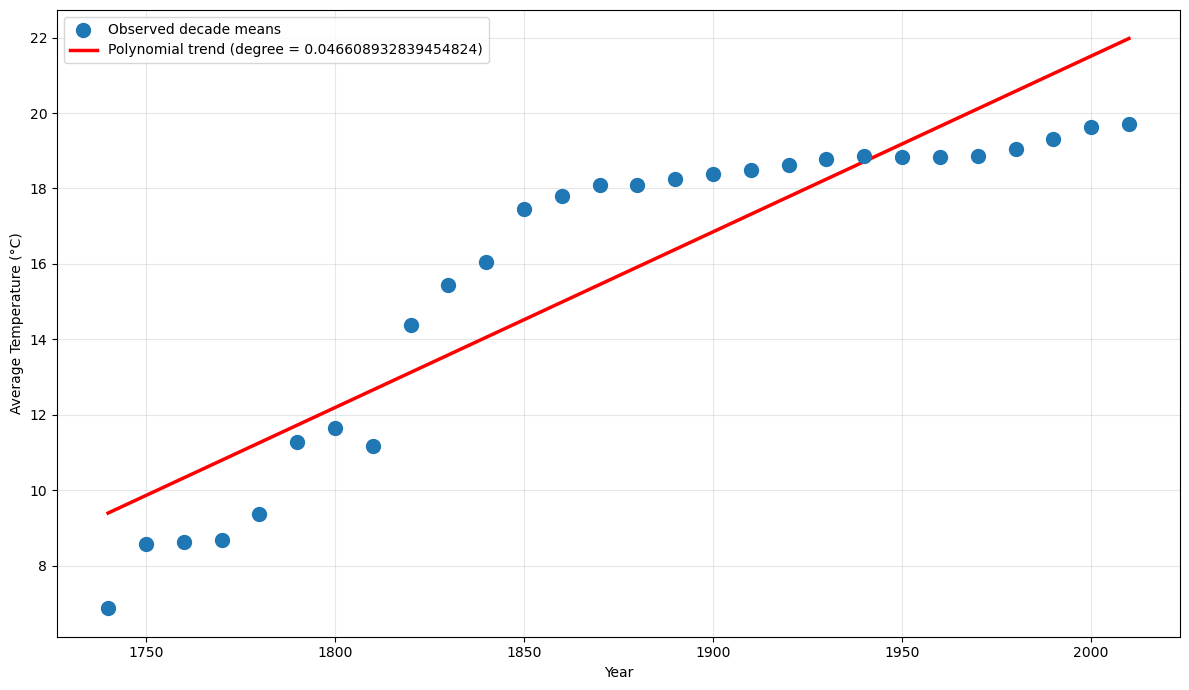

In [155]:
plt.figure(figsize=(12, 7))
plt.scatter(decades_mean_temp.index, decades_mean_temp, color='tab:blue', s=100, label='Observed decade means', zorder=5)

plt.plot(decades_mean_temp.index, x_smooth, color='red', linewidth=2.5,
         label=f'Polynomial trend (degree = {slope})')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# heatmap of temp changes

In [156]:
decades_mean = df.groupby(['Country', 'decades_str'])['AverageTemperature'].mean().reset_index()
decades_mean

,Country,decades_str,AverageTemperature
0,Afghanistan,1830s,16.217147
1,Afghanistan,1840s,13.658134
2,Afghanistan,1850s,13.557317
3,Afghanistan,1860s,13.477967
4,Afghanistan,1870s,13.845850
...,...,...,...
5049,Åland,1970s,5.600417
5050,Åland,1980s,5.366067
5051,Åland,1990s,6.295967
5052,Åland,2000s,6.816300


In [158]:
# Pivot to create a matrix: rows = countries, columns = decades
pivot_temp = decades_mean.pivot(index='Country', columns='decades_str', values='AverageTemperature')
pivot_temp

decades_str,1740s,1750s,1760s,1770s,1780s,1790s,1800s,1810s,1820s,1830s,...,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.217147,...,13.706792,13.691550,14.386883,14.000892,13.961283,14.035983,14.595183,14.732458,15.365650,15.521185
Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.027567,24.155042,24.250850,24.099275,24.155550,24.151075,24.428567,24.626283,24.891983,25.034062
Albania,10.947040,12.332912,12.386633,12.802883,12.516992,12.769667,12.652933,12.032733,12.452017,12.054758,...,12.822600,12.897350,12.667342,12.999192,12.919900,12.610950,12.775675,13.149892,13.529558,13.919464
Algeria,NaN,NaN,NaN,NaN,22.985535,22.972788,23.000456,22.060167,22.732183,22.544067,...,22.995742,23.200767,23.259642,23.092575,23.232308,22.929833,23.515033,23.651742,24.192267,24.572110
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.399842,26.734708,26.766642,26.773925,26.650492,26.756117,26.911825,27.103125,27.246783,27.274848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Western Sahara,NaN,NaN,NaN,NaN,22.128843,21.951833,21.645210,21.896313,22.062932,21.840583,...,22.454908,22.285733,22.444217,22.297975,22.589075,22.293025,22.917942,23.082625,23.381150,23.635230
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.092833,25.961617,26.377800,26.150275,26.273042,26.300225,26.280400,26.768392,27.225242,27.497067
Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.266275,21.093425,21.380275,21.325883,21.310158,21.252458,21.666858,21.999275,21.922075,21.777120


In [159]:
# Sort decades chronologically
pivot_temp = pivot_temp.sort_index(axis=1)
pivot_temp

decades_str,1740s,1750s,1760s,1770s,1780s,1790s,1800s,1810s,1820s,1830s,...,1920s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.217147,...,13.706792,13.691550,14.386883,14.000892,13.961283,14.035983,14.595183,14.732458,15.365650,15.521185
Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.027567,24.155042,24.250850,24.099275,24.155550,24.151075,24.428567,24.626283,24.891983,25.034062
Albania,10.947040,12.332912,12.386633,12.802883,12.516992,12.769667,12.652933,12.032733,12.452017,12.054758,...,12.822600,12.897350,12.667342,12.999192,12.919900,12.610950,12.775675,13.149892,13.529558,13.919464
Algeria,NaN,NaN,NaN,NaN,22.985535,22.972788,23.000456,22.060167,22.732183,22.544067,...,22.995742,23.200767,23.259642,23.092575,23.232308,22.929833,23.515033,23.651742,24.192267,24.572110
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.399842,26.734708,26.766642,26.773925,26.650492,26.756117,26.911825,27.103125,27.246783,27.274848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Western Sahara,NaN,NaN,NaN,NaN,22.128843,21.951833,21.645210,21.896313,22.062932,21.840583,...,22.454908,22.285733,22.444217,22.297975,22.589075,22.293025,22.917942,23.082625,23.381150,23.635230
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.092833,25.961617,26.377800,26.150275,26.273042,26.300225,26.280400,26.768392,27.225242,27.497067
Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.266275,21.093425,21.380275,21.325883,21.310158,21.252458,21.666858,21.999275,21.922075,21.777120


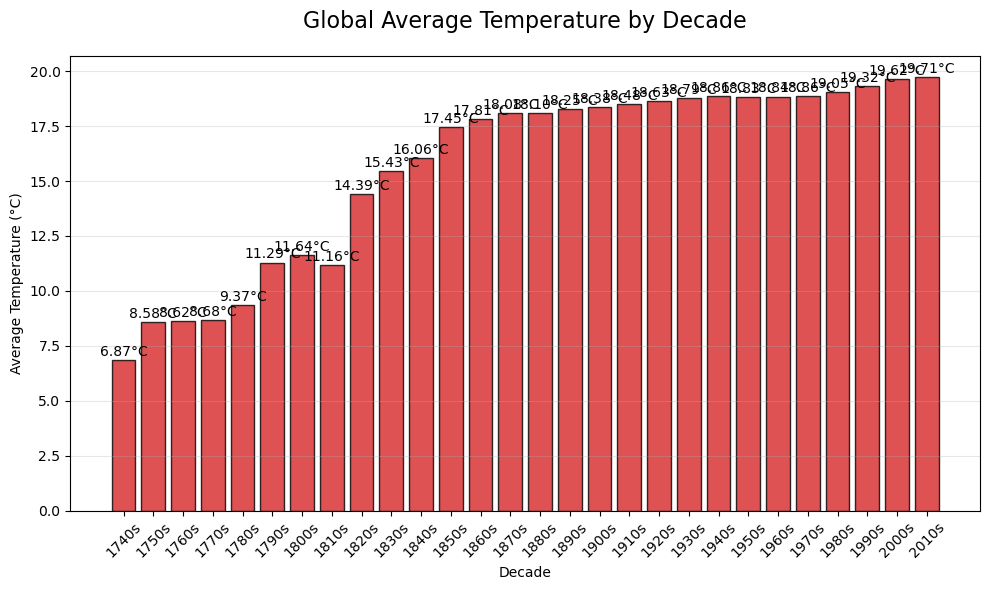

In [163]:
global_decade_temp = df.groupby('decades_str')['AverageTemperature'].mean()

global_decade_temp = global_decade_temp.sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(global_decade_temp.index, global_decade_temp.values, 
               color='tab:red', edgecolor='black', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}°C', ha='center', va='bottom', fontsize=10)

plt.title('Global Average Temperature by Decade', fontsize=16, pad=20)
plt.xlabel('Decade')
plt.ylabel('Average Temperature (°C)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

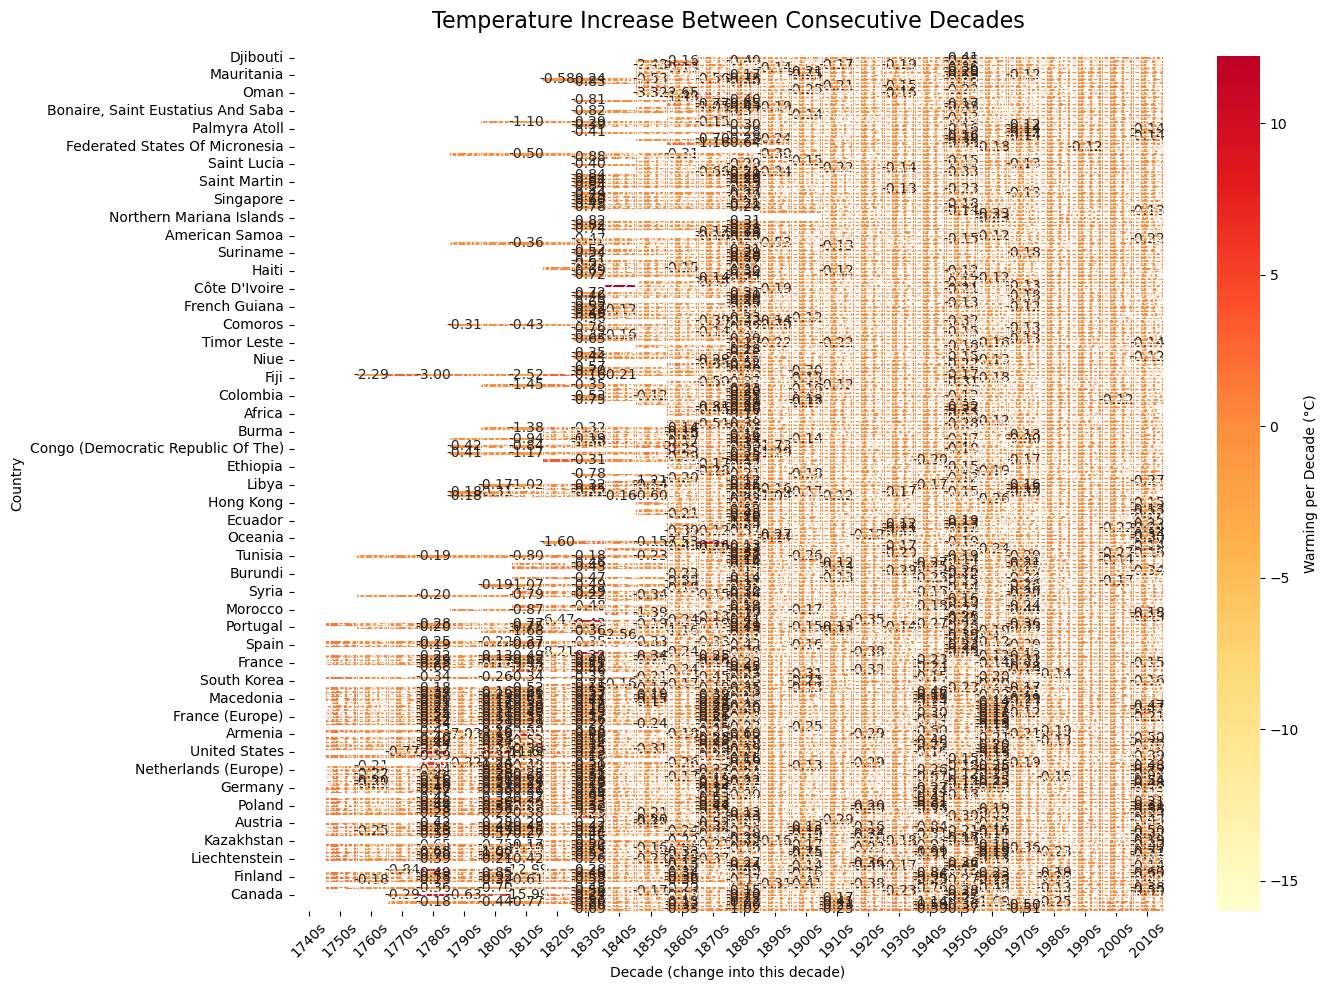

In [164]:
# Difference between consecutive decades
temp_diff = pivot_temp.diff(axis=1)  # e.g., 1970s - 1960s, 1980s - 1970s, etc.

plt.figure(figsize=(14, 10))
sns.heatmap(
    temp_diff,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    center=0.1,
    linewidths=0.5,
    cbar_kws={'label': 'Warming per Decade (°C)'}
)

plt.title('Temperature Increase Between Consecutive Decades', fontsize=16, pad=20)
plt.xlabel('Decade (change into this decade)')
plt.ylabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot three trends

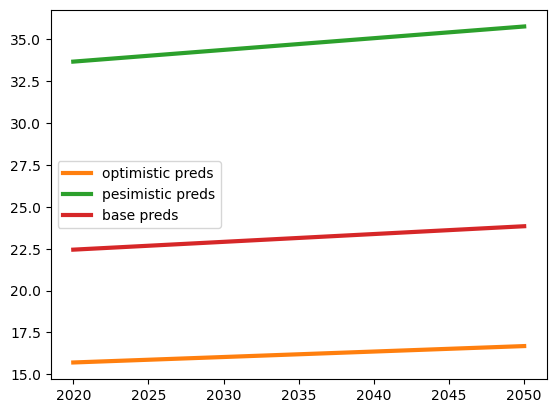

In [171]:
plt.plot(future_decades, op_preds, color='#ff7f0e', linewidth=3, label='optimistic preds')
plt.plot(future_years, pe_preds, color='#2ca02c', linewidth=3, label='pesimistic preds')
plt.plot(future_years, base_pred, color='#d62728', linewidth=3, label='base preds')
plt.legend()
plt.show()

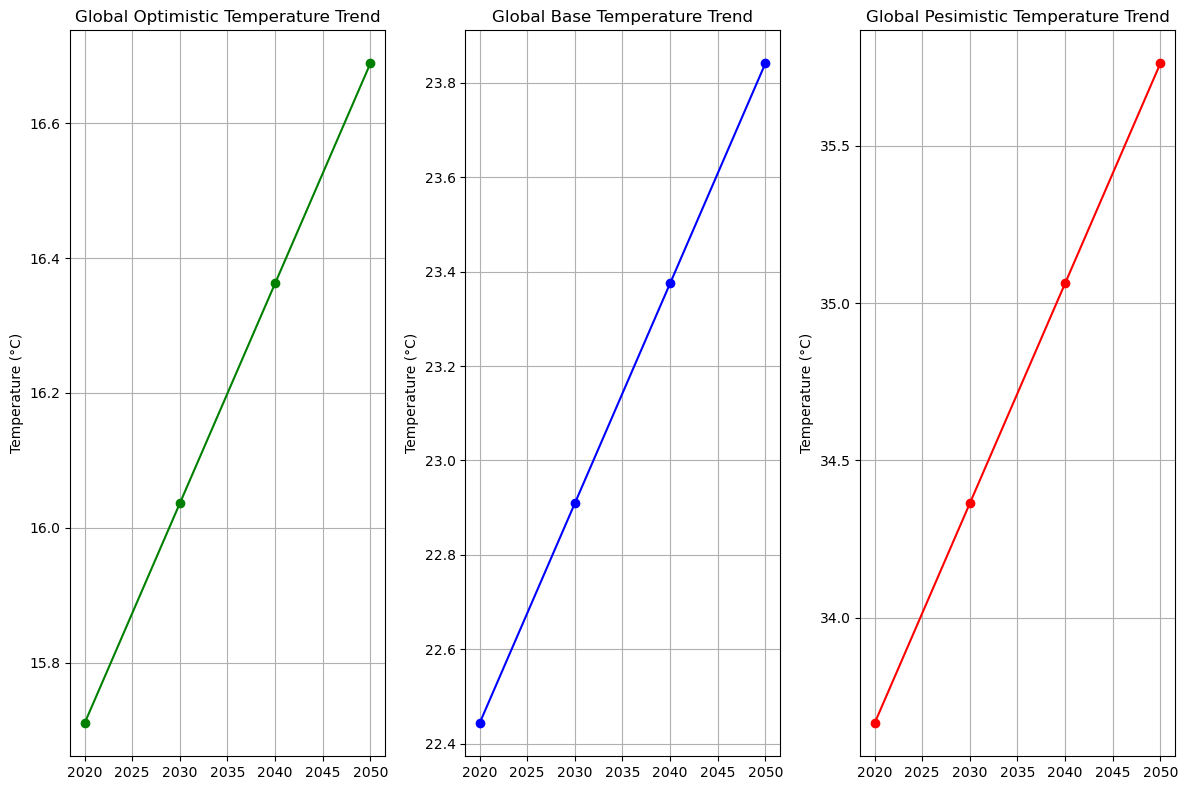

In [177]:
fig, axes = plt.subplots(1, 3, figsize=(12, 8))
axes[0].plot(future_decades, op_preds, 'o-', color='green')
axes[0].set_title('Global Optimistic Temperature Trend')
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(True)

axes[1].plot(future_decades, base_pred, 'o-', color='blue')
axes[1].set_title('Global Base Temperature Trend')
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(True)

axes[2].plot(future_decades, pe_preds, 'o-', color='red')
axes[2].set_title('Global Pesimistic Temperature Trend')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True)

plt.tight_layout()
plt.show()